# **References paper -**

Collaborative Filtering - https://dl.acm.org/doi/pdf/10.1145/371920.372071

Neural Collaborative Filtering - https://dl.acm.org/doi/pdf/10.1145/3038912.3052569

In [ ]:
import pandas as pd
import numpy as np

# To create deep learning models
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from tensorflow.keras.utils import plot_model

# To stack sparse matrices
from scipy.sparse import vstack
# For visulazation
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


In [ ]:
# Load datasets
movie_ratings = pd.read_csv('/content/ratings.csv')
movie_ratings.drop("timestamp", axis=1, inplace=True)
print('Shape Movie-ratings:\t{}'.format(movie_ratings.shape))
movie_ratings.head()

Shape Movie-ratings:	(100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Transform The User-Ratings To User-Movie-Matrix

In [ ]:
# Create a user-movie matrix with empty values
df_p = movie_ratings.pivot_table(index='userId', columns='movieId', values='rating')
df_p.sample(6)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,5.0,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
513,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = movie_ratings
#create mappings
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1.
#y = df["rating"].values
y = df["rating"].apply(lambda x: (x - 0.5) / (4.5)).values

# Prepare training, validation and testing data
# training on 90% of the data, validating on 10% and testing on 1000 seperate samples.
train_indices = int(0.9 * df.shape[0])

x_train, x_val, x_test, y_train, y_val, y_test = (
    x[:train_indices],
    x[train_indices:100000],
    x[100000:],
    y[:train_indices],
    y[train_indices:100000],
    y[100000:],
)

### create the model

In [ ]:
#embed both users and movies in to 50-dimensional vectors
embedding_size= 50

# Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=embedding_size,
                           input_dim=num_users,
                           input_length=1,
                           embeddings_initializer="he_normal",
                           embeddings_regularizer=keras.regularizers.l2(1e-6),
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size,
                            input_dim=num_movies,
                            input_length=1,
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='movie_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])
#concat = Dot(1, normalize=False)([user_vector, movie_vector])

# Combine with dense layers
dense1 = Dense(256)(concat)
dense = Dropout(0.2)(dense1)
y = Dense(1, activation="sigmoid")(dense) # The sigmoid activation forces the rating to between 0 and 1


# compile model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse',  optimizer = 'adam')


# Fit the model
history = model.fit(x = [x_train[:,0],x_train[:,1]],
          y = y_train,
          batch_size=256,
          epochs=4,
          validation_data = ([x_val[:,0], x_val[:,1]], y_val),
          )

Epoch 1/4
355/355 [==============================] - 5s 11ms/step - loss: 0.0414 - val_loss: 0.0386
Epoch 2/4
355/355 [==============================] - 4s 11ms/step - loss: 0.0353 - val_loss: 0.0386
Epoch 3/4
355/355 [==============================] - 5s 13ms/step - loss: 0.0342 - val_loss: 0.0384
Epoch 4/4
355/355 [==============================] - 4s 12ms/step - loss: 0.0337 - val_loss: 0.0386


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                30500     ['user[0][0]']                
                                                                                                  
 movie_embedding (Embedding  (None, 1, 50)                486200    ['movie[0][0]']               
 )                                                                                            

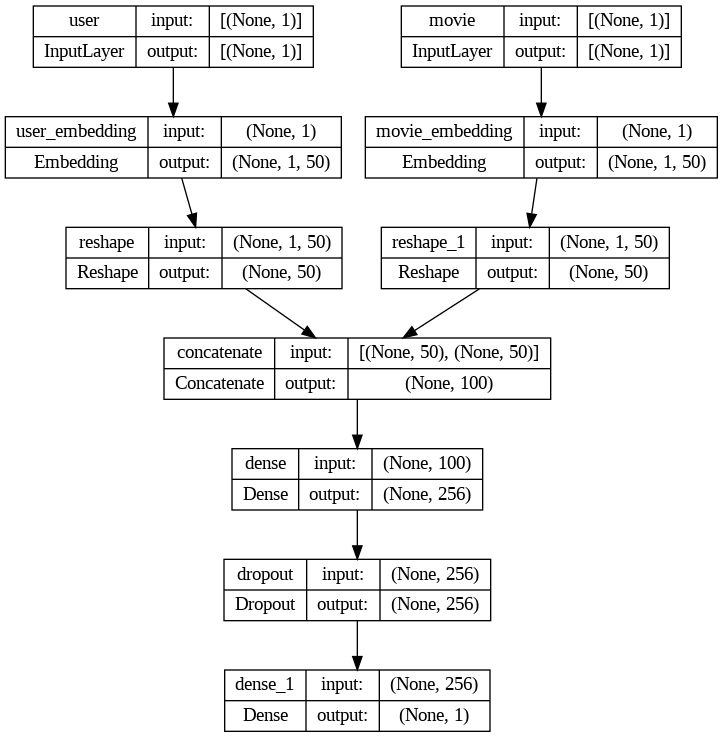

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

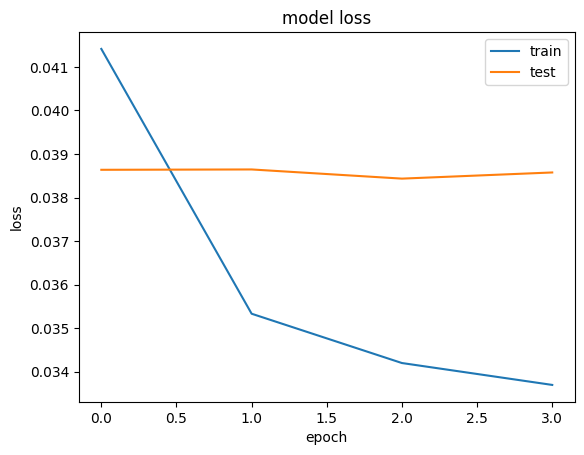

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [ ]:
#  Compute RMSE
y_pred = model.predict([x_test[:,0], x_test[:,1]])
y_true =  y_test

rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result : {:.4f} RMSE'.format(rmse))

27/27 [==============================] - 0s 2ms/step


Testing Result : 0.1987 RMSE


In [ ]:
# Test model
p , a = (model.predict([x_test[:15,0], x_test[:15,1]]) , y_test[:15])
print("ratings are Normalized between 0 and 1 (0.5 - 5.0)")
for i in range(len(p)):
    print("predicted rating is : "+ str(np.round(p[i],2)) +"        actual rating was : "+ str(round(a[i],2)) )

1/1 [==============================] - 0s 23ms/step
ratings are Normalized between 0 and 1 (0.5 - 5.0)
predicted rating is : [0.68]        actual rating was : 0.78
predicted rating is : [0.67]        actual rating was : 0.78
predicted rating is : [0.88]        actual rating was : 1.0
predicted rating is : [0.52]        actual rating was : 0.44
predicted rating is : [0.63]        actual rating was : 1.0
predicted rating is : [0.62]        actual rating was : 0.56
predicted rating is : [0.41]        actual rating was : 0.56
predicted rating is : [0.83]        actual rating was : 0.78
predicted rating is : [0.4]        actual rating was : 0.33
predicted rating is : [0.66]        actual rating was : 0.78
predicted rating is : [0.5]        actual rating was : 0.33
predicted rating is : [0.49]        actual rating was : 0.33
predicted rating is : [0.83]        actual rating was : 0.78
predicted rating is : [0.72]        actual rating was : 0.67
predicted rating is : [0.83]        actual rati

The predictions are quite close to the actual ratings, now the model can be used to reconstruct the original matrix and to predict the missing ratings for each user.

In [ ]:
movie_df = pd.read_csv('/content/movies.csv')

# display recommendations
def get_recomendations(user_id):
      movies_watched_by_user = df[df.userId == user_id]
      movies_not_watched = movie_df[
          ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
      movies_not_watched = list(
          set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
      )
      movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
      user_encoder = user2user_encoded.get(user_id)
      user_movie_array = np.hstack(
          ([[user_id]] * len(movies_not_watched), movies_not_watched)
      )

      ratings = model.predict([user_movie_array[:,0], user_movie_array[:,1]]).flatten()

      top_ratings_indices = ratings.argsort()[-10:][::-1]
      recommended_movie_ids = [
          movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
      ]

      print("Showing recommendations for user: {}".format(user_id))
      print("=" * 36)
      print("Movies with high ratings from user")
      print("-" * 34)
      top_movies_user = (
          movies_watched_by_user.sort_values(by="rating", ascending=False)
          .head(5)
          .movieId.values
      )
      movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
      for row in movie_df_rows.itertuples():
          print(row.title, ":", row.genres)

      print("-" * 30)
      print(" Top 10 movie recommendations")
      print("-" * 30)
      recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
      for row in recommended_movies.itertuples():
          print(row.title, ":", row.genres)

In [ ]:
#enter a user_id (between 1 - 610)
get_recomendations(1)

297/297 [==============================] - 1s 3ms/step
Showing recommendations for user: 1
Movies with high ratings from user
----------------------------------
A Suitable Boy (2020) : Drama|Romance
Andaz Apna Apna (2015) : Action|Comedy|Romance
Jaane Tu... Ya Jaane Na (2017) : Comedy|Drama|Romance
Mumbai Saga (2022) : Action|Crime
Saawariya (2006) : Drama|Musical|Romance
------------------------------
 Top 10 movie recommendations
------------------------------
Dil Se.. (1998) : Drama|Romance
Ramprasad Ki Tehrvi (2019) : Comedy|Drama
The Broken News (2022) : Drama
Krishna Vrinda Vihari (2022) : Comedy|Drama|Romance
Chithram (2020) : Comedy|Drama|Musical
Shabd (1994) : Drama|Thriller
Pavam I.A. Ivachan (2006) : Comedy|Drama
Chaavu Kaburu Challaga (2013) : Comedy
Neninthe (1995) : Action|Drama
Bhavnao Ko Samjho (2022) : Action|Comedy|Drama
